In [14]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import math
import numpy as np
import sklearn.cluster as skclust 
import copy

def load_all_fitnesses(filename,obj) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        best_fitnesses = []
        best_ind_id = []
        avg_fitnesses = []
        pop_size= []
        nb_eval = []
        nb_eval_tot = 0
        for row in csv_data :
            best_fitness = 0
            best_id = 0
            avg_fitness = 0
            nb_eval_tot += int(row[1])
            for i in range(3,len(row[:-1]),int(row[2])) :
                if(float(row[i+obj]) > best_fitness) :
                    best_fitness = float(row[i+obj])
                    best_id = int(i/int(row[2]) - 1)
                avg_fitness += float(row[i+obj])
            avg_fitness = avg_fitness/float(row[1])
            avg_fitnesses.append(avg_fitness)
            best_fitnesses.append(best_fitness)
            best_ind_id.append(best_id)
            nb_eval.append(nb_eval_tot)
            pop_size.append(int(row[1]))
            
    return nb_eval, best_ind_id, best_fitnesses, avg_fitnesses, pop_size

def load_ind_fitnesses(filename,obj):
    with open(filename) as file:
        csv_data = csv.reader(file,delimiter=',')
        lines = []
        for row in csv_data:
            for i in range(3,int(row[1])+3):
                lines.append([int(row[0]),i-3,float(row[i])])
    return lines

def load_controller_archive(filename):
    lines = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        coord = [0]*3
        state = 0
        nbr_param = 0
        i=0
        for row in csv_data:
            if(len(row) == 3):
                coord[0] = int(row[0])
                coord[1] = int(row[1])
                coord[2] = int(row[2])
                state = 1
                i=0
            elif(state == 1):
                nbr_param = int(row[0])
                state = 2
            elif(state == 2):
                nbr_param += int(row[0])
                state = 3
            elif(state == 3 and i < nbr_param):
                i+=1
            elif(state == 3 and i >= nbr_param):
                lines.append([coord[0],coord[1],coord[2],float(row[0])])
    return pd.DataFrame(data=lines,columns=["number of wheels","number of joints","number of sensors","fitness"])
                
def load_number_of_eval_per_gen(foldername,nbr_gen):
    nbr_eval_per_gen = [0]*nbr_gen
    for filename in os.listdir(foldername):
        if(filename.split('_')[0] != "controllers"):
            continue
        gen = int(filename.split('_')[1])
        with open(foldername + '/' + filename) as file:
            csv_data = csv.reader(file,delimiter=',')
            nbr_eval = 0
            for row in csv_data:
                if(len(row) == 4):
                    nbr_eval+=1
        nbr_eval_per_gen[gen] += nbr_eval
   # for i in range(1,len(nbr_eval_per_gen)):
    #    nbr_eval_per_gen[i] += nbr_eval_per_gen[i-1]
    return nbr_eval_per_gen
    
def load_controllers_fitnesses(foldername,nbr_gen):
    best_fits = [[] for _ in range(nbr_gen)]
    learn_prog = [[] for _ in range(nbr_gen)]
    learn_delta = [[] for _ in range(nbr_gen)]
    for filename in os.listdir(foldername):
        if(filename.split('_')[0] != "controllers"):
            continue
        gen = int(filename.split('_')[1])
        
        with open(foldername + '/' + filename) as file:
            csv_data = csv.reader(file,delimiter=',')
            best_fit = 0
            init_fit = 0
            counter = 0
            for row in csv_data:
                if(len(row) == 2):
                    if(init_fit == 0):
                        init_fit = float(row[0])
                    if(best_fit < float(row[0])):
                        best_fit = float(row[0])
                    counter+=1
            learn_prog[gen].append((best_fit - init_fit))
            learn_delta[gen].append((best_fit - init_fit)/counter)
            best_fits[gen].append(best_fit)
        
    return best_fits, learn_delta, learn_prog    
    
    
def load_descriptor(filename,desc_size) :
    '''
    Load a list of descriptor from a file
    Trait descriptor: <width,depth,height,voxels,wheels,sensor,joint,caster>
    '''
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        descriptors = []
        for row in csv_data :
            desc = []
            for i in range(desc_size+2) :
                desc.append(float(row[i]))
            descriptors.append(desc)
        return np.array(descriptors)
    
def sparsness_per_gen(descriptors,pop_size):
    sparsness = []
    for i in range(int(len(descriptors)/pop_size)):
        tmp_desc = descriptors[i*pop_size:(i+1)*pop_size]
        spars = 0
        for o in range(len(tmp_desc)):
            for p in range(len(tmp_desc)):
                if(o==p):
                    continue
                dist = np.linalg.norm(np.array(tmp_desc[o][3:])-np.array(tmp_desc[p][3:]))
            spars += dist
        sparsness.append([i,spars/10])
    return sparsness

def read_parameters(filename):
    '''
    Read a parameter and return a dictionnary
    '''
    parameters = dict()
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            parameters[row[0]] = row[2]
    return parameters

def plot_hist_nbr_rob(title,data,organ,bins,nb_rob):
    fig = plt.gcf()
    fig.set_size_inches(25,10)
    ax = sns.histplot(data=data,multiple="stack",bins=bins,x='gen',hue=organ,palette="light:b")
    ax.set_ylabel("Number of robots",fontsize=20)
    ax.set_xlabel("Generations",fontsize=20)
    plt.title(title,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(range(1,nb_rob+1),labels=[1]*nb_rob,fontsize=20)
    plt.show()

In [121]:
organ_lines = []

In [122]:
exp_folder = "/home/leni/are-logs/mnipes_steps_frontier/wa/100/"

In [123]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne in nbr_eval:
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    nbr_ctrl_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(float(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        for i,line in ctrl_arch.iterrows():
            if(line["fitness"] > 0):
                nbr_ctrl+=1
        nbr_ctrl_v.append(nbr_ctrl)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    print(acc_nbr_eval[-1])

    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))
    
    for gen, bf, af, nc,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,nbr_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*2000,bf,af,ane,nc,ne,np.mean(lp),np.max(lp)])
wa_c_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of controllers","number of evaluations","average learning progress","best learning progress"])

20
22760
20
32850
20
22990
20
23820
20
21540


In [124]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [125]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
print(len(lines))
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","100"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","100"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","100"])

2000


In [126]:
exp_folder = "/home/leni/are-logs/mnipes_steps_frontier/wa/150/"

In [127]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne in nbr_eval:
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    nbr_ctrl_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(float(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        for i,line in ctrl_arch.iterrows():
            if(line["fitness"] > 0):
                nbr_ctrl+=1
        nbr_ctrl_v.append(nbr_ctrl)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    print(acc_nbr_eval[-1])
    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af, nc,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,nbr_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*3000,bf,af,ane,nc,ne,np.mean(lp),np.max(lp)])
wa_cc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of controllers","number of evaluations","average learning progress","best learning progress"])

30
29780
30
41730
30
60610
30
26730
30
57420


In [128]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [129]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
print(len(lines))
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","150"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","150"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","150"])

3000


In [130]:
exp_folder = "/home/leni/are-logs/mnipes_steps_frontier/wa/200/"

In [131]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne in nbr_eval:
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    nbr_ctrl_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(float(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        for i,line in ctrl_arch.iterrows():
            if(line["fitness"] > 0):
                nbr_ctrl+=1
        nbr_ctrl_v.append(nbr_ctrl)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    print(acc_nbr_eval[-1])
    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af, nc,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,nbr_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*4000,bf,af,ane,nc,ne,np.mean(lp),np.max(lp)])
wa_dc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of controllers","number of evaluations","average learning progress","best learning progress"])

20
29600
20
39020
20
38930
20
33570
20
67420


In [132]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [133]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
print(len(lines))
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","200"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","200"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","200"])

2000


In [153]:
exp_folder = "/home/leni/are-logs/mnipes_steps_frontier/wa/300/"

In [154]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne in nbr_eval:
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    nbr_ctrl_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(float(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        for i,line in ctrl_arch.iterrows():
            if(line["fitness"] > 0):
                nbr_ctrl+=1
        nbr_ctrl_v.append(nbr_ctrl)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    print(acc_nbr_eval[-1])

    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))
    print(learn_prog[11])
    for gen, bf, af, nc,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,nbr_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*6000,bf,af,ane,nc,ne,np.mean(lp),np.max(lp)])
wa_tc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of controllers","number of evaluations","average learning progress","best learning progress"])

15
33170
[0.31136600000000003, 0.014646999999999966, 0.38773100000000005, 0.23165900000000006, 0.256169, 0.34170599999999995, 0.3517579999999999, 0.09720200000000001, 0.34089499999999995, 0.31744700000000003, 0.31518900000000005, 0.288925, 0.32675299999999996, 0.333557, 0.348144, 0.009549999999999947, 0.33335800000000004, 0.365379, 0.6221650000000001, 0.332063]
15
40370
[0.53167, 0.529922, 0.529836, 0.2410770000000001, 0.3585649999999999, 0.27151099999999995, 0.0019379999999999953, 0.0, 0.6070329999999999, 0.398343, 0.22585499999999992, 0.3296, 0.323986, 0.29219400000000006, 0.35514499999999993, 0.270497, 0.24420299999999995, 0.30185000000000006, 0.02829499999999996, 0.0]
15
40010
[0.34857400000000005, 0.469936, 0.614331, 0.4260520000000001, 0.353294, 0.42380699999999993, 0.378294, 0.30236399999999997, 0.310225, 0.361575, 0.35942300000000005, 0.387509, 0.16684199999999993, 0.537435, 0.30523, 0.33090200000000003, 0.40201600000000004, 0.613919, 0.334751, 0.0013340000000000574]
15
62420
[

In [136]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [137]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
print(len(lines))
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","300"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","300"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","300"])

1500


In [155]:
exp_folder = "/home/leni/are-logs/mnipes_steps_frontier/wa/500/"

In [156]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne in nbr_eval:
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    nbr_ctrl_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(float(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        for i,line in ctrl_arch.iterrows():
            if(line["fitness"] > 0):
                nbr_ctrl+=1
        nbr_ctrl_v.append(nbr_ctrl)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    print(acc_nbr_eval[-1])

    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af, nc,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,nbr_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*10000,bf,af,ane,nc,ne,np.mean(lp),np.max(lp)])
wa_qc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of controllers","number of evaluations","average learning progress","best learning progress"])

10
63580
9
42190
10
59040
6
60450
10
52920


In [140]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [141]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","500"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","500"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","500"])


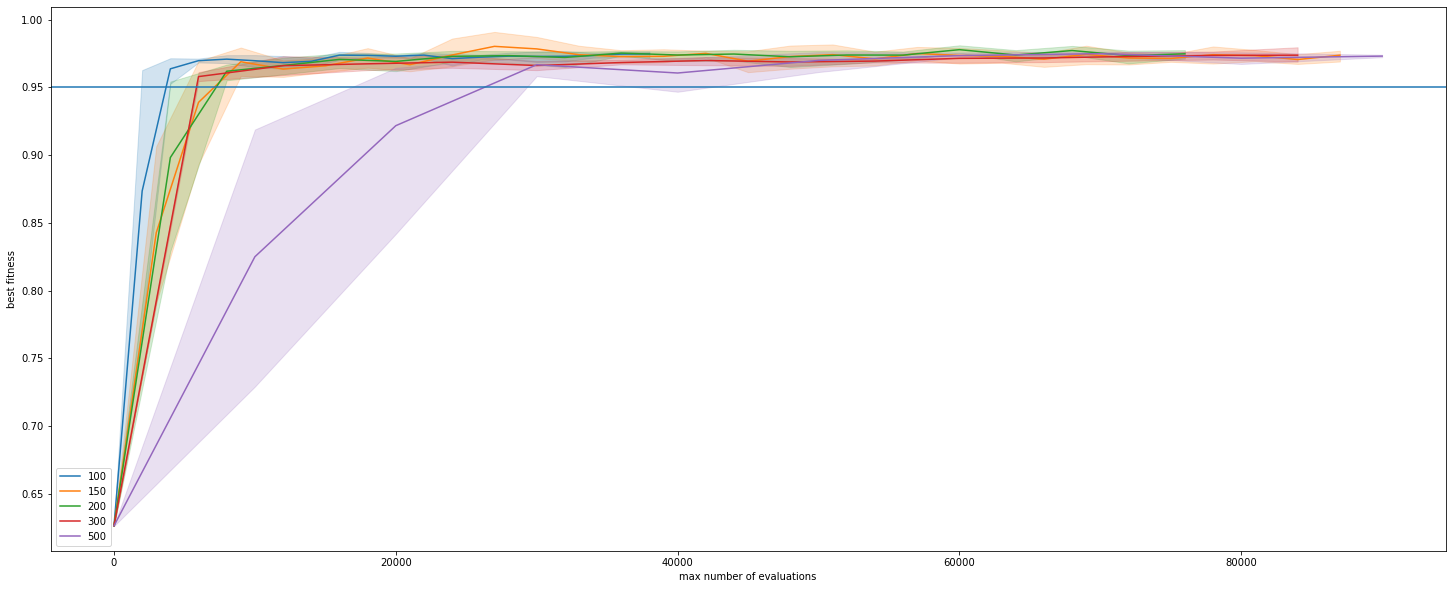

In [149]:
fig = plt.gcf()
fig.set_size_inches(25,10)
sns.lineplot(data=wa_c_data,x="max number of evaluations",y="best fitness",label="100")
sns.lineplot(data=wa_cc_data,x="max number of evaluations",y="best fitness",label="150")
sns.lineplot(data=wa_dc_data,x="max number of evaluations",y="best fitness",label="200")
sns.lineplot(data=wa_tc_data,x="max number of evaluations",y="best fitness",label="300")
ax = sns.lineplot(data=wa_qc_data,x="max number of evaluations",y="best fitness",label="500")
ax.axhline([0.95])
#ax.set_xlim(0,5)
#plt.legend(["success threshold","100","150","200","300","100"])

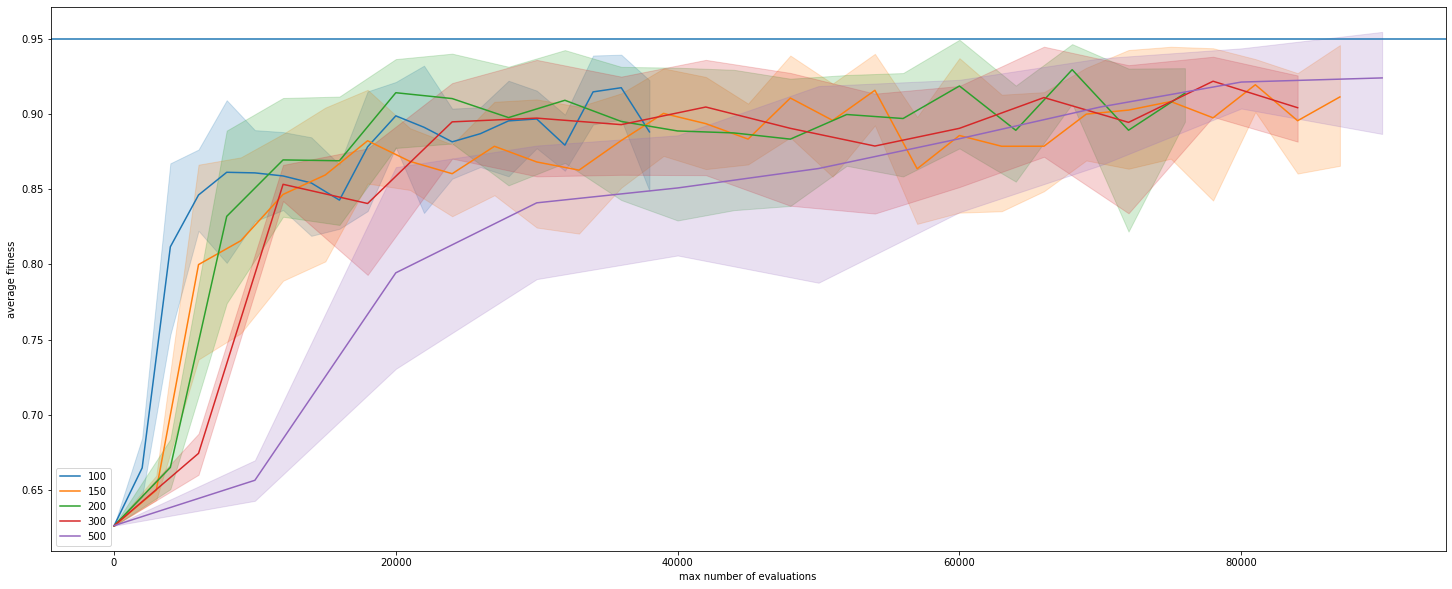

In [148]:
fig = plt.gcf()
fig.set_size_inches(25,10)
sns.lineplot(data=wa_c_data,x="max number of evaluations",y="average fitness",label="100")
sns.lineplot(data=wa_cc_data,x="max number of evaluations",y="average fitness",label="150")
sns.lineplot(data=wa_dc_data,x="max number of evaluations",y="average fitness",label="200")
sns.lineplot(data=wa_tc_data,x="max number of evaluations",y="average fitness",label="300")
ax = sns.lineplot(data=wa_qc_data,x="max number of evaluations",y="average fitness",label="500")
ax.axhline([0.95])
#ax.set_xlim(0,40000)
#plt.legend(["success threshold","500","300","200","150","100"])

(0, 80000)

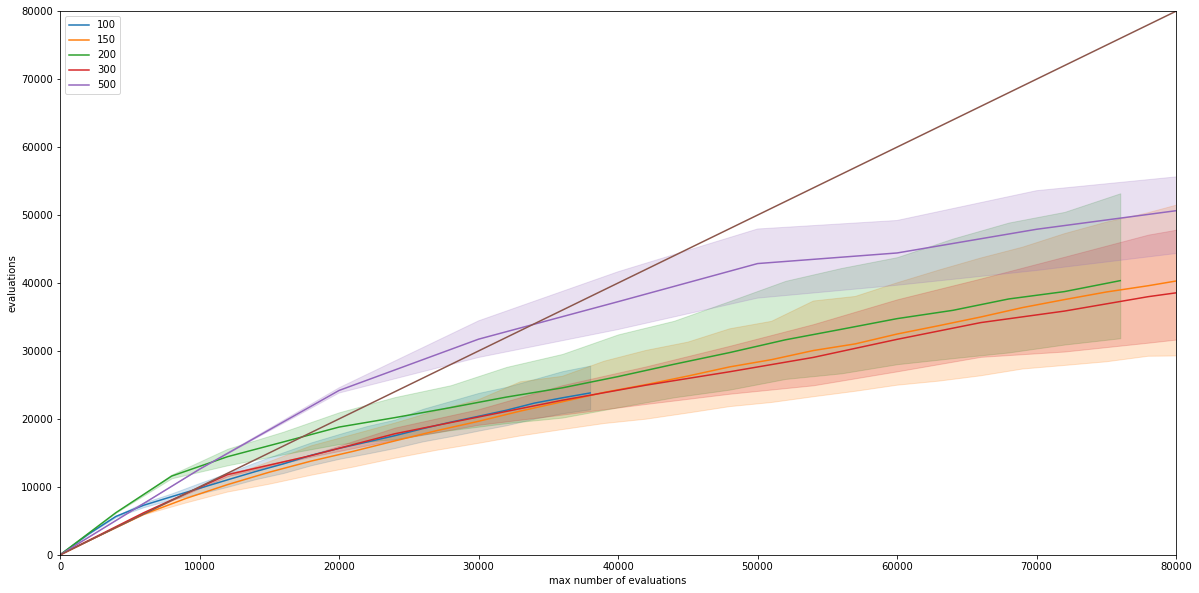

In [144]:
fig = plt.gcf()
fig.set_size_inches(20,10)
sns.lineplot(data=wa_c_data,x="max number of evaluations",y="evaluations",label="100")
sns.lineplot(data=wa_cc_data,x="max number of evaluations",y="evaluations",label="150")
sns.lineplot(data=wa_dc_data,x="max number of evaluations",y="evaluations",label="200")
sns.lineplot(data=wa_tc_data,x="max number of evaluations",y="evaluations",label="300")
ax = sns.lineplot(data=wa_qc_data,x="max number of evaluations",y="evaluations",label="500")
plt.plot([x for x in range(80000)],[x for x in range(80000)])
ax.set_xlim(0,80000)
ax.set_ylim(0,80000)
#plt.legend(["y=x","not segmented","segmented"])

(0, 0.03)

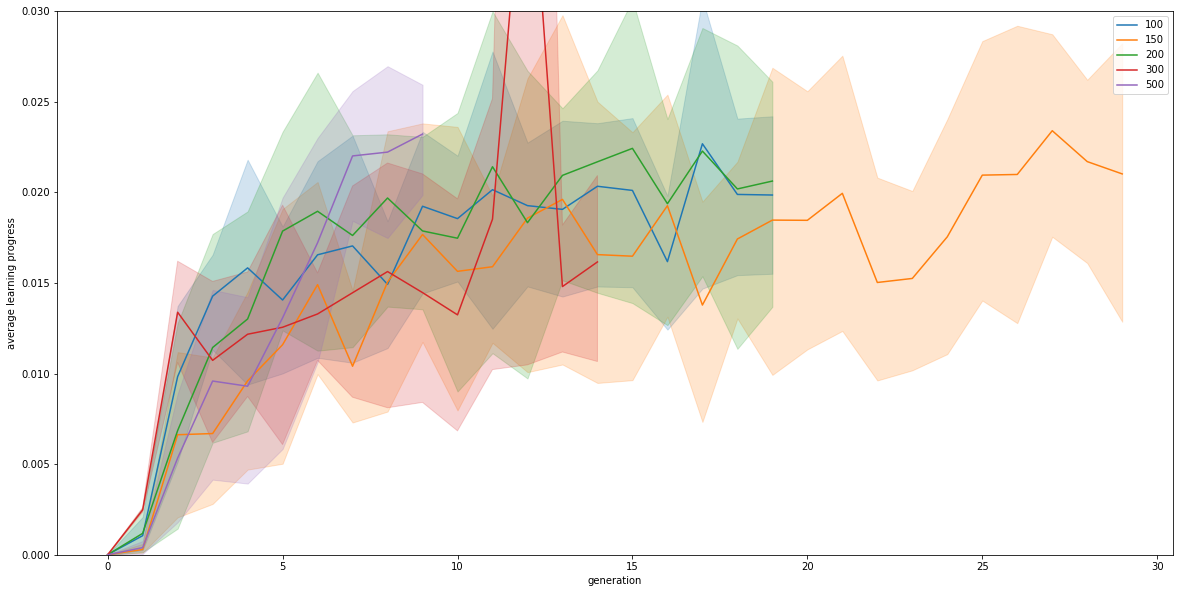

In [164]:
fig = plt.gcf()
fig.set_size_inches(20,10)
sns.lineplot(data=wa_c_data,x="generation",y="average learning progress",label="100")
sns.lineplot(data=wa_cc_data,x="generation",y="average learning progress",label="150")
sns.lineplot(data=wa_dc_data,x="generation",y="average learning progress",label="200")
sns.lineplot(data=wa_tc_data,x="generation",y="average learning progress",label="300")
ax = sns.lineplot(data=wa_qc_data,x="generation",y="average learning progress",label="500")
ax.set_ylim(0,0.03)

(0, 0.1)

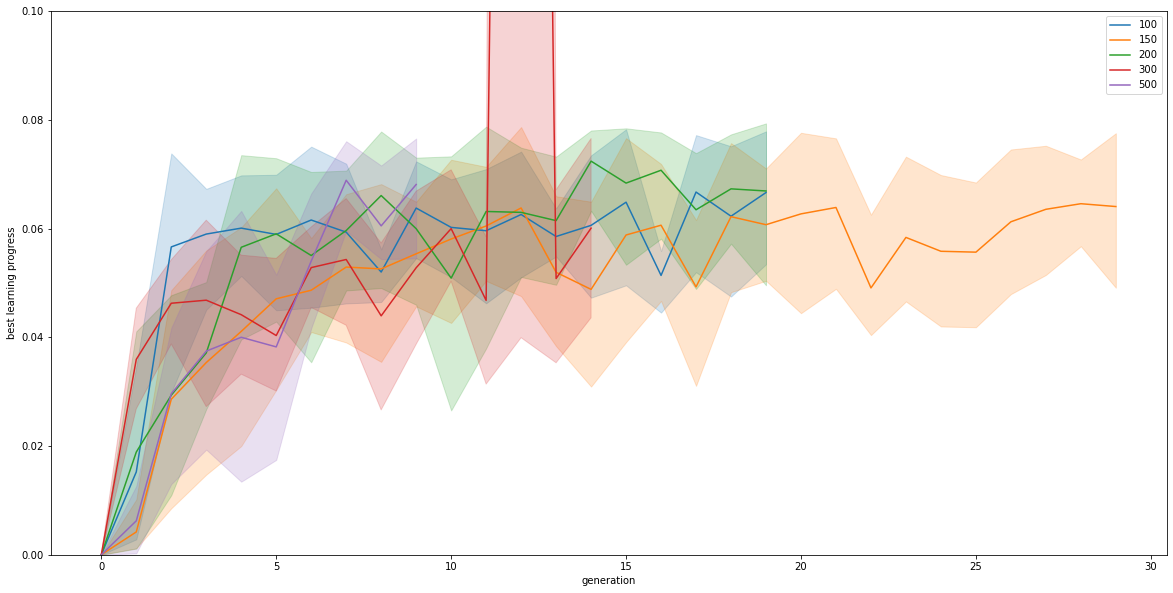

In [162]:
fig = plt.gcf()
fig.set_size_inches(20,10)
sns.lineplot(data=wa_c_data,x="generation",y="best learning progress",label="100")
sns.lineplot(data=wa_cc_data,x="generation",y="best learning progress",label="150")
sns.lineplot(data=wa_dc_data,x="generation",y="best learning progress",label="200")
sns.lineplot(data=wa_tc_data,x="generation",y="best learning progress",label="300")
ax = sns.lineplot(data=wa_qc_data,x="generation",y="best learning progress",label="500")
ax.set_ylim([0,0.1])

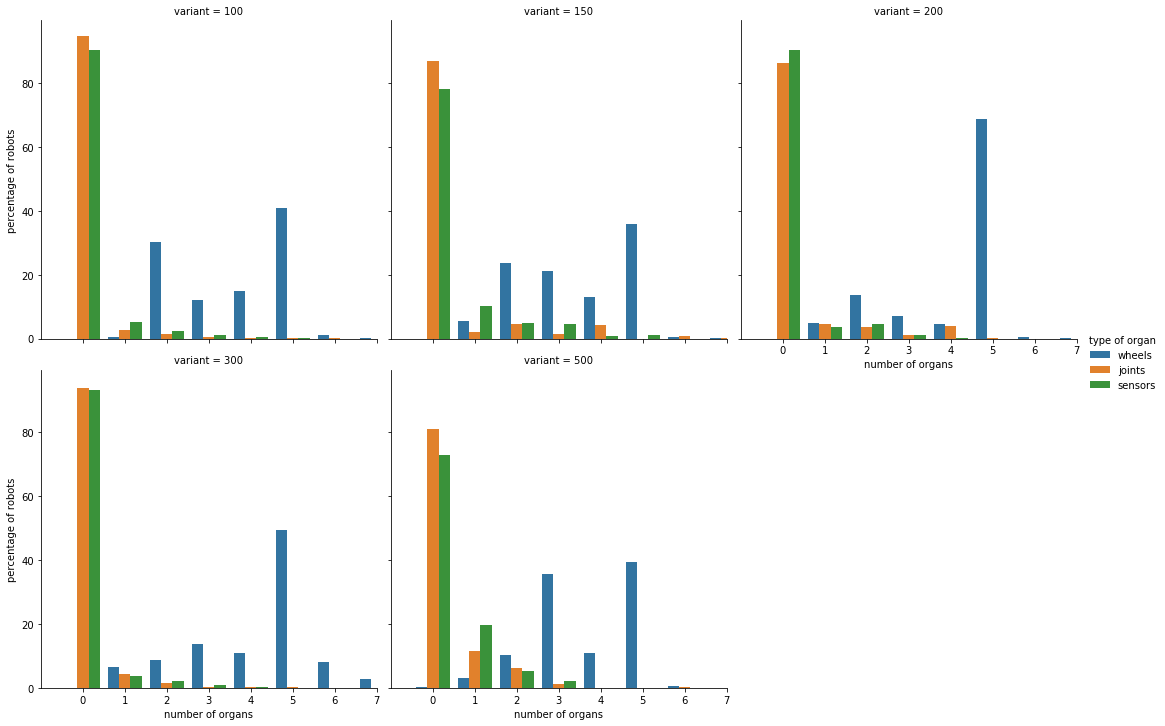

In [165]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=3)
g.set(xlim=[-1,7])